# Learning RNNs

This notebook will mirror the content in Chapter 12 ("A Language Model from Scatch") of [*Deep Learning for Coders with fastai & PyTorch*](https://github.com/fastai/fastbook) by Jeremy Howard & Sylvain Gugger, as well as Jeremy's ["Practical Deep Learning"](https://course.fast.ai/) course.

In an attempt to make sure I understand what is going on under the hood, I'll avoid using the conveniences provided by fastai. That being said, I am not implementing things from scratch and consider anything in Pytorch as fair game.

I'll also make it my own by trying to use different datasets and adding anything else that occurs to me that might make the models perform better. We'll see what actually works.

## Prep

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    project_path = "/content/drive/MyDrive/Projects/code/LearningDeepLearning/nbs"
    !pip install datasets
    !pip install transformers
else:
    project_path = "."

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0


## Imports

In [ ]:
import os
from pathlib import Path
from collections import defaultdict
from psutil import virtual_memory
from functools import partial
import time
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import tensor
from torch.utils.data import DataLoader

from datasets import Dataset, DatasetDict, load_dataset, load_from_disk
from transformers import GPT2Tokenizer

# Data Prep: TinyStories

TinyStories is a dataset developed by Ronen Eldan and Yuanzhi Li and described in their paper ["TinyStories: How Small Can Language Models Be and Still Speak Coherent English?"](https://arxiv.org/abs/2305.07759). From the paper, TinyStories is "a synthetic dataset of short stories that only contain words that a typical 3 to 4-year-olds usually understand, generated by GPT-3.5 and GPT-4." The paper goes on to show that they can train "small" language models (<10 million parameters) that nevertheless "produce fluent and consistent stories with several paragraphs that are diverse and have almost perfect grammer, and demonstrate reasoning capabilities."

We're starting with very rudimentary models with much simpler architecture and even fewer parameters, but let's see how good we can make this.

In [ ]:
token_limit = 192e4 # limiting amount of data used to speed things up, can relax later

## Load and inspect dataset

In [ ]:
project_dir = Path(project_path)
data_dir = Path(project_dir/'data')
data_dir.mkdir(exist_ok=True)

In [ ]:
train_fn = "TinyStoriesV2-GPT4-train.txt"
train_url = "https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStoriesV2-GPT4-train.txt"
test_fn = "TinyStoriesV2-GPT4-valid.txt"
test_url = "https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStoriesV2-GPT4-valid.txt"

In [ ]:
data_dir/train_fn

PosixPath('/content/drive/MyDrive/Projects/code/LearningDeepLearning2/nbs/data/TinyStoriesV2-GPT4-train.txt')

In [ ]:
if not os.path.exists(data_dir/train_fn):
    os.system(f'wget {train_url} -O {data_dir/train_fn} --progress=dot:mega')
if not os.path.exists(data_dir/test_fn):
    os.system(f'wget {test_url} -O {data_dir/test_fn} --progress=dot:mega')

In [ ]:
# note: if last doc doesn't end in endoftext then it is omitted
def tinystories_generator(file_path, skip_first=False):
    current_doc = ""
    is_first = True
    with open(file_path, "r") as f:
        for line in f:
            if line.startswith("<|endoftext|>"):
                if not skip_first or not is_first:
                    yield {"text": current_doc.strip() + "<|endoftext|>"}
                is_first = False
                current_doc = ""
            else:
                current_doc += line

In [ ]:
train_ds = Dataset.from_generator(partial(tinystories_generator, file_path=data_dir/train_fn))
test_ds = Dataset.from_generator(partial(tinystories_generator, file_path=data_dir/test_fn, skip_first=True))

ds = DatasetDict({
    'train': train_ds,
    'test': test_ds
})

Generating train split: 0 examples [00:00, ? examples/s]

KeyboardInterrupt: ignored

In [ ]:
ds

In [ ]:
ds['train'][0:2]['text']

In [ ]:
ds['test'][0:2]

## Tokenize and inspect tokens

In [ ]:
# Load the pretrained GPT-Neo tokenizer as is used in the TinyStories paper
tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")

In [ ]:
tokenizer.vocab_size

50257

In [ ]:
tds_filename = 'tinystories_tokenized_gpt-neo-1.3B'
if os.path.exists(data_dir/tds_filename):
    tds = load_from_disk(data_dir/tds_filename)
else:
    tds = ds.map(lambda e: tokenizer(e['text']), batched=True, remove_columns="text")
    tds.save_to_disk(data_dir/tds_filename)

In [ ]:
tds

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 2717699
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 27629
    })
})

In [ ]:
tf_fn = 'tokenfreq_tinystories_tokenized_gpt-neo-1.3B.pkl'
if os.path.exists(data_dir/tf_fn):
    tf = pd.read_pickle(data_dir/tf_fn)
else:
    # Initialize a defaultdict to keep track of the frequency of each token
    token_freq = defaultdict(int)
    # Define a function to update the token frequencies
    def update_freqs(batch):
        for token_list in batch['input_ids']:
            for token_id in token_list:
                token_freq[token_id] += 1
        return {}
    # Apply the function to the dataset
    tds['train'].map(update_freqs, batched=True, batch_size=10000)
    # Put it in a dataframe and compute cdf
    tf = pd.DataFrame(dict(token_freq).items(), columns=('token', 'freq'))
    tf['token'] = tf['token'].astype('category')
    tf['token_str'] = tf['token'].apply(tokenizer.decode)
    tf.sort_values('freq', ascending=False, inplace=True)
    tf.reset_index(inplace=True, drop=True)
    tf['cdf'] = tf['freq'].cumsum() / tf['freq'].sum()
    # Save to disk
    tf.to_pickle(data_dir/tf_fn)
tf

,token,freq,token_str,cdf
0,13,41825583,.,0.077245
1,11,23298942,",",0.120274
2,262,20828658,the,0.158741
3,290,19476061,and,0.194709
4,257,15074432,a,0.222549
...,...,...,...,...
27989,35172,1,Elves,1.000000
27990,16976,1,specialized,1.000000
27991,21942,1,injustice,1.000000
27992,38868,1,adier,1.000000


In [ ]:
# 28k tokens in the training set vs. 50k in the tokenizer vocab
len(tf), tokenizer.vocab_size

(27994, 50257)

In [ ]:
# top ten tokens by frequency, accounting for 30% of all tokens
tf.head(10)

,token,freq,token_str,cdf
0,13,41825583,.,0.077245
1,11,23298942,",",0.120274
2,262,20828658,the,0.158741
3,290,19476061,and,0.194709
4,257,15074432,a,0.222549
5,284,14906882,to,0.250080
6,373,10594487,was,0.269646
7,198,9119907,\n,0.286489
8,1119,5226509,They,0.296141
9,340,5141200,it,0.305636


In [ ]:
# the top 44 account for 50% of all tokens
tf.iloc[(0.5 - tf['cdf']).abs().argmin()]

token           20037
freq          1995606
token_str        Lily
cdf          0.501679
Name: 44, dtype: object

In [ ]:
# the top ~800 account for 90% of all tokens
tf.iloc[(0.9 - tf['cdf']).abs().argmin()]

token           1382
freq           58844
token_str      build
cdf          0.89995
Name: 793, dtype: object

In [ ]:
# the top ~3700 account for 99% of all tokens
tf.iloc[(0.99 - tf['cdf']).abs().argmin()]

token           10291
freq             3663
token_str     wanting
cdf          0.990001
Name: 3709, dtype: object

In [ ]:
# the top 10k tokens account for 99.93% of tokens, tokens past this appear <120 times in the training set
tf.iloc[10000]

token             3033
freq               119
token_str     features
cdf           0.999304
Name: 10000, dtype: object

In [ ]:
# 3k tokens only appear once, 10k appear 10 or fewer times
(tf['freq'] == 1).sum(), (tf['freq'] <= 10).sum()

(3175, 10009)

# Training LMModel 3 (RNN with Backpropogation Through Time)

In [ ]:
bs = 64
lr = 3e-3
epochs = 1
seq_len = 3

In [ ]:
vocab_size = tokenizer.vocab_size
vocab_size

50257

In [ ]:
if torch.backends.mps.is_available():
    def_device = device_name = 'mps'
elif torch.cuda.is_available():
    def_device = 'cuda'
    device_name = torch.cuda.get_device_name(0)
else:
    def_device = device_name = 'cpu'
def_device, device_name

('cuda', 'NVIDIA A100-SXM4-40GB')

In [ ]:
virtual_memory().total / 1e9

89.636769792

In [ ]:
def get_sequences_from_doc(doc, seq_len=3):
    return [(doc[i:i+seq_len], doc[i+seq_len]) for i in range(0,len(doc)-seq_len-1,seq_len)]

def get_sequences_from_ds(ds, token_limit):
    seqs = []
    for doc in ds:
        i = 0 if len(seqs)==0 else i+1
        seqs.extend(get_sequences_from_doc(tensor(doc['input_ids']), seq_len))
        if i % 1000 == 0:
            print(f'{len(seqs)}/{token_limit} done')
        if len(seqs)*seq_len >= token_limit:
            break
    return seqs

In [ ]:
print('train')
train_seqs = get_sequences_from_ds(tds['train'], token_limit)
print('test')
test_seqs = get_sequences_from_ds(tds['test'], token_limit)

train
62/1920000.0 done
65885/1920000.0 done
132398/1920000.0 done
198478/1920000.0 done
265368/1920000.0 done
331051/1920000.0 done
396882/1920000.0 done
462737/1920000.0 done
529767/1920000.0 done
596213/1920000.0 done
test
69/1920000.0 done
64681/1920000.0 done
129571/1920000.0 done
194245/1920000.0 done
259498/1920000.0 done
324271/1920000.0 done
389586/1920000.0 done
453914/1920000.0 done
519785/1920000.0 done
585284/1920000.0 done


In [ ]:
len(train_seqs), len(test_seqs)

(640015, 640006)

In [ ]:
def group_chunks(ds, bs):
  m = len(ds)//bs
  new_ds = []
  for i in range(m): new_ds += ds[i:m*bs:m]
  return new_ds

In [ ]:
train_dl = DataLoader(group_chunks(train_seqs, bs), batch_size=bs, shuffle=False, drop_last=True)
test_dl = DataLoader(group_chunks(train_seqs, bs), batch_size=bs, shuffle=False, drop_last=True)

In [ ]:
len(train_dl), len(test_dl)

(10000, 10000)

In [ ]:
class LMModel3(nn.Module):
    def __init__(self, vocab_sz, n_hidden):
      super().__init__()
      self.i_h = nn.Embedding(vocab_sz, n_hidden)
      self.h_h = nn.Linear(n_hidden, n_hidden)
      self.h_o = nn.Linear(n_hidden,vocab_sz)
      self.h = 0

    def forward(self, x):
        for i in range(3):
            self.h = self.h + self.i_h(x[:,i])
            self.h = F.relu(self.h_h(self.h))
        out = self.h_o(self.h)
        self.h = self.h.detach()
        return out

    def reset(self): self.h = 0

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions based on 3 most recent tokens
            logits = self(idx[:,-3:]) # (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [ ]:
model = LMModel3(vocab_size, 64).to(def_device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = 0.9)

In [ ]:
model

LMModel3(
  (i_h): Embedding(50257, 64)
  (h_h): Linear(in_features=64, out_features=64, bias=True)
  (h_o): Linear(in_features=64, out_features=50257, bias=True)
)

In [ ]:
def get_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
%%time
start_time = time.time()
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward (calc predictions) + backward (calc loss & gradients) +
        # optimize (step the weights)
        outputs = model(inputs.to(def_device))
        loss = criterion(outputs, labels.to(def_device))
        loss.backward()
        optimizer.step()
        # tally loss
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
          print(f'\t[{epoch + 1}, {i + 1:5d}] loss: {running_loss / i:.3f}')
    # reset hidden state before validation
    model.reset()
    # calc validation loss and accuracy
    running_valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for valid_i, valid_data in enumerate(test_dl, 0):
            inputs, labels = valid_data
            outputs = model(inputs.to(def_device))
            valid_loss = criterion(outputs, labels.to(def_device))
            running_valid_loss += valid_loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(def_device)).sum().item()
    # print stats
    print(f'[{epoch + 1}, {i + 1:5d}] train loss: {running_loss / i:.3f} valid loss: {running_valid_loss / valid_i:.3f} valid i: {valid_i} accuracy: {correct / total:.3f}')
    # reset hidden state before next epoch
    model.reset()
print('Finished Training')
end_time = time.time()
print(f'{end_time - start_time} seconds')

	[1,   200] loss: 10.512
	[1,   400] loss: 9.494
	[1,   600] loss: 8.719
	[1,   800] loss: 8.150
	[1,  1000] loss: 7.779
	[1,  1200] loss: 7.505
	[1,  1400] loss: 7.276
	[1,  1600] loss: 7.087
	[1,  1800] loss: 6.936
	[1,  2000] loss: 6.806
	[1,  2200] loss: 6.685
	[1,  2400] loss: 6.578
	[1,  2600] loss: 6.482
	[1,  2800] loss: 6.401
	[1,  3000] loss: 6.324
	[1,  3200] loss: 6.256
	[1,  3400] loss: 6.196
	[1,  3600] loss: 6.138
	[1,  3800] loss: 6.084
	[1,  4000] loss: 6.038
	[1,  4200] loss: 5.988
	[1,  4400] loss: 5.946
	[1,  4600] loss: 5.904
	[1,  4800] loss: 5.868
	[1,  5000] loss: 5.831
	[1,  5200] loss: 5.794
	[1,  5400] loss: 5.762
	[1,  5600] loss: 5.730
	[1,  5800] loss: 5.701
	[1,  6000] loss: 5.673
	[1,  6200] loss: 5.643
	[1,  6400] loss: 5.617
	[1,  6600] loss: 5.593
	[1,  6800] loss: 5.571
	[1,  7000] loss: 5.549
	[1,  7200] loss: 5.528
	[1,  7400] loss: 5.507
	[1,  7600] loss: 5.486
	[1,  7800] loss: 5.466
	[1,  8000] loss: 5.447
	[1,  8200] loss: 5.430
	[1,  8400] los

In [ ]:
# do some generation
prompt = tensor(tds['train'][0]['input_ids'][:3])
gen_txt = model.generate(idx = prompt.view(1,3).to(def_device), max_new_tokens=20)[0].tolist()
print(tokenizer.decode(gen_txt))

**Log results**

In [ ]:
log_dir = Path(project_dir/'logs')
log_dir.mkdir(exist_ok=True)

In [ ]:
log_path = log_dir/'log.pkl'
if os.path.exists(log_path):
    log = pd.read_pickle(log_path)
else:
    log = pd.DataFrame(columns=['model', 'params', 'device_name', 'vocab_size', 'train_tokens', 'test_tokens', 'batch_size',
                                'epochs', 'train_time', 'train_loss', 'test_loss', 'accuracy', 'sample'])

In [ ]:
log = \
pd.concat([log,
           pd.DataFrame({'model': model.__class__.__name__, 'params': get_params(model),'device_name': device_name,
                         'vocab_size': tokenizer.vocab_size, 'train_tokens': seq_len*len(train_dl)*bs,
                         'test_tokens': seq_len*len(test_dl)*bs,
                         'batch_size': bs, 'epochs':epochs, 'train_time': end_time-start_time,
                         'train_loss': running_loss / i, 'test_loss': running_valid_loss / valid_i, 'accuracy': correct / total,
                         'sample': tokenizer.decode(gen_txt)}, index=[len(log)])
          ])

In [ ]:
log

,model,params,device_name,vocab_size,train_tokens,test_tokens,batch_size,epochs,train_time,train_loss,test_loss,accuracy,sample
0,LMModel3,6487313,mps,50257,1920000,1920000,64,1,284.984944,5.295207,4.621000,0.231564,Once upon a time colorful. They thinks it.\nOn...
1,LMModel3,6487313,Tesla T4,50257,1920000,1920000,64,1,53.554449,5.290185,4.608912,0.233263,Once upon a time on the toys in and theyAUD so...
2,LMModel3,6487313,Tesla V100-SXM2-16GB,50257,1920000,1920000,64,1,42.597042,5.283650,4.595851,0.232405,Once upon a time tried to worried of. The dog ...
3,LMModel3,6487313,NVIDIA A100-SXM4-40GB,50257,1920000,1920000,64,1,33.035805,5.291462,4.612990,0.230420,Once upon a time they in mom needed and Worldw...


In [ ]:
pd.to_pickle(log, log_path)

## Notes

First, very simple model (LMModel3) training for one epoch with less than 2m tokens took 5 minutes on my Macbook and less than a minute on Colab with a real GPU. The A100 was only twice as fast at the T4, which just suggests we are no where near to the point where we need the power of the A100.

# Training LMModel4 (Predict next token after every token)

In [ ]:
bs = 64
lr = 3e-3
epochs = 5
seq_len = 16

In [ ]:
vocab_size = tokenizer.vocab_size
vocab_size

50257

In [ ]:
if torch.backends.mps.is_available():
    def_device = device_name = 'mps'
elif torch.cuda.is_available():
    def_device = 'cuda'
    device_name = torch.cuda.get_device_name(0)
else:
    def_device = device_name = 'cpu'
def_device, device_name

('cuda', 'Tesla T4')

In [ ]:
def get_sequences_from_doc(doc, seq_len):
    return [(doc[i:i+seq_len], doc[i+1:i+seq_len+1]) for i in range(0,len(doc)-seq_len-1,seq_len)]

def get_sequences_from_ds(ds, seq_len, token_limit):
    seqs = []
    for doc in ds:
        i = 0 if len(seqs)==0 else i+1
        seqs.extend(get_sequences_from_doc(tensor(doc['input_ids']), seq_len))
        if i % 1000 == 0:
            print(f'{len(seqs)}/{token_limit} done')
        if len(seqs)*seq_len >= token_limit:
            break
    return seqs

In [ ]:
print('getting training sequences')
train_seqs = get_sequences_from_ds(tds['train'], seq_len, token_limit)
print('getting testing sequences')
test_seqs = get_sequences_from_ds(tds['test'], seq_len, token_limit)

getting training sequences
62/1920000.0 done
65885/1920000.0 done
132398/1920000.0 done
198478/1920000.0 done
265368/1920000.0 done
331051/1920000.0 done
396882/1920000.0 done
462737/1920000.0 done
529767/1920000.0 done
596213/1920000.0 done
getting testing sequences
69/1920000.0 done
64681/1920000.0 done
129571/1920000.0 done
194245/1920000.0 done
259498/1920000.0 done
324271/1920000.0 done
389586/1920000.0 done
453914/1920000.0 done
519785/1920000.0 done
585284/1920000.0 done


In [ ]:
len(train_seqs), len(test_seqs)

(640015, 640006)

In [ ]:
train_seqs[0]

(tensor([7454, 2402,  257]), tensor([2402,  257,  640]))

In [ ]:
train_seqs[1]

(tensor([640, 612, 373]), tensor([612, 373, 257]))

In [ ]:
train_dl = DataLoader(group_chunks(train_seqs, bs), batch_size=bs, shuffle=False, drop_last=True)
test_dl = DataLoader(group_chunks(train_seqs, bs), batch_size=bs, shuffle=False, drop_last=True)

In [ ]:
class LMModel4(nn.Module):
    def __init__(self, vocab_sz, n_hidden):
      super().__init__()
      self.i_h = nn.Embedding(vocab_sz, n_hidden)
      self.h_h = nn.Linear(n_hidden, n_hidden)
      self.h_o = nn.Linear(n_hidden,vocab_sz)
      self.h = 0

    def forward(self, x):
        outs = []
        for i in range(seq_len):
            self.h = self.h + self.i_h(x[:,i])
            self.h = F.relu(self.h_h(self.h))
            outs.append(self.h_o(self.h))
        self.h = self.h.detach()
        return torch.stack(outs, dim=1)

    def reset(self): self.h = 0

    def generate(self, x, max_new_tokens):
        # x is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions based on seq_len most recent tokens
            logits = self(x[:,-seq_len:]) # (B, T, C)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            x_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            x = torch.cat((x, x_next), dim=1) # (B, T+1)
        return x

In [ ]:
def train(train_dl, test_dl, model, epochs, one_batch=False):
    start_time = time.time()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_dl, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward (calc predictions) + backward (calc loss & gradients) +
            # optimize (step the weights)
            outputs = model(inputs.to(def_device))
            # flatten outputs to (BATCH_SIZE * SEQ_LEN, VOCAB_SIZE)
            # flatten labels to (BATCH_SIZE * SEQ_LEN)
            loss = criterion(outputs.view(-1, vocab_size), labels.view(-1).to(def_device))
            loss.backward()
            optimizer.step()
            # tally loss
            running_loss += loss.item()
            if i % 200 == 199:    # print every 200 mini-batches
                print(f'\t[{epoch + 1}, {i+1:5d}] loss: {running_loss / (i+1):.3f}')
            if one_batch:
                if epoch % 100 == 0:
                    print(f'\t[{epoch + 1}, {i+1:5d}] loss: {running_loss / (i+1):.3f}')
                break
        # reset hidden state before validation
        model.reset()
        if one_batch:
            continue
        # calc validation loss and accuracy
        running_valid_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for valid_i, valid_data in enumerate(test_dl, 0):
                inputs, labels = valid_data
                outputs = model(inputs.to(def_device))
                valid_loss = criterion(outputs.view(-1, vocab_size), labels.view(-1).to(def_device))
                running_valid_loss += valid_loss.item()
                # max across VOCAB_SIZE dim, result shape (BATCH_SIZE, SEQ_LEN)
                _, predicted = torch.max(outputs, 2)
                total += torch.numel(labels)
                correct += (predicted == labels.to(def_device)).sum().item()
        # print stats
        print(f'[{epoch + 1}, {i + 1:5d}] train loss: {running_loss / (i+1):.3f} valid loss: {running_valid_loss / (valid_i+1):.3f} valid i: {valid_i} accuracy: {correct / total:.3f}')
        # reset hidden state before next epoch
        model.reset()
    print('Finished Training')
    train_time = time.time() - start_time
    print(f'{train_time} seconds')
    train_loss = running_loss / (i+1)
    if one_batch:
        test_loss = None
        _, predicted = torch.max(outputs, 2)
        total = torch.numel(labels)
        correct = (predicted == labels.to(def_device)).sum().item()
    else:
        test_loss = running_valid_loss / (valid_i+1)
    accuracy = correct / total
    return train_time, train_loss, test_loss, accuracy

In [ ]:
# sanity check: overfit on a single batch
model = LMModel4(vocab_size, 64).to(def_device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
_, overfit_train_loss, _, overfit_train_accuracy = train(train_dl, test_dl, model, epochs=2000, one_batch=True)
print(f'{overfit_train_loss=:0.2f}\n{overfit_train_accuracy=:0.2f}')

	[1,     1] loss: 10.845
	[101,     1] loss: 9.619
	[201,     1] loss: 6.620
	[301,     1] loss: 4.063
	[401,     1] loss: 2.352
	[501,     1] loss: 1.382
	[601,     1] loss: 0.860
	[701,     1] loss: 0.546
	[801,     1] loss: 0.370
	[901,     1] loss: 0.273
	[1001,     1] loss: 0.223
	[1101,     1] loss: 0.193
	[1201,     1] loss: 0.176
	[1301,     1] loss: 0.167
	[1401,     1] loss: 0.161
	[1501,     1] loss: 0.157
	[1601,     1] loss: 0.154
	[1701,     1] loss: 0.152
	[1801,     1] loss: 0.150
	[1901,     1] loss: 0.149
Finished Training
13.018299341201782 seconds
overfit_train_loss=0.15
overfit_train_accuracy=0.93


In [ ]:
# init
model = LMModel4(vocab_size, 64).to(def_device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
model

LMModel4(
  (i_h): Embedding(50257, 64)
  (h_h): Linear(in_features=64, out_features=64, bias=True)
  (h_o): Linear(in_features=64, out_features=50257, bias=True)
)

In [ ]:
%%time
# train
train_time, train_loss, test_loss, accuracy = train(train_dl, test_dl, model, epochs)

	[1,   200] loss: 10.254
	[1,   400] loss: 9.283
	[1,   600] loss: 8.553
	[1,   800] loss: 8.045
	[1,  1000] loss: 7.695
	[1,  1200] loss: 7.426
	[1,  1400] loss: 7.209
	[1,  1600] loss: 7.031
	[1,  1800] loss: 6.882
	[1,  2000] loss: 6.753
	[1,  2200] loss: 6.637
	[1,  2400] loss: 6.536
	[1,  2600] loss: 6.441
	[1,  2800] loss: 6.359
	[1,  3000] loss: 6.287
	[1,  3200] loss: 6.218
	[1,  3400] loss: 6.159
	[1,  3600] loss: 6.101
	[1,  3800] loss: 6.048
	[1,  4000] loss: 6.001
	[1,  4200] loss: 5.952
	[1,  4400] loss: 5.909
	[1,  4600] loss: 5.868
	[1,  4800] loss: 5.831
	[1,  5000] loss: 5.795
	[1,  5200] loss: 5.758
	[1,  5400] loss: 5.726
	[1,  5600] loss: 5.695
	[1,  5800] loss: 5.666
	[1,  6000] loss: 5.638
	[1,  6200] loss: 5.610
	[1,  6400] loss: 5.583
	[1,  6600] loss: 5.560
	[1,  6800] loss: 5.538
	[1,  7000] loss: 5.517
	[1,  7200] loss: 5.495
	[1,  7400] loss: 5.473
	[1,  7600] loss: 5.452
	[1,  7800] loss: 5.432
	[1,  8000] loss: 5.412
	[1,  8200] loss: 5.395
	[1,  8400] los

KeyboardInterrupt: ignored

In [ ]:
# do some generation
model.reset()
with torch.no_grad():
    prompt = tensor(tds['train'][0]['input_ids'][:seq_len]).view(1, -1)
    gen_txt = model.generate(prompt.to(def_device), max_new_tokens=20)[0].tolist()
    print(tokenizer.decode(gen_txt))

Once upon a time, why lived all day, a little chest moved fixed to play with near as to listen food


**Log results**

In [ ]:
def get_log_path(project_dir):
    log_dir = Path(project_dir/'logs')
    log_dir.mkdir(exist_ok=True)
    return log_dir/'log.pkl'

def load_log(project_dir):
    log_path = get_log_path(project_dir)
    if os.path.exists(log_path):
        log = pd.read_pickle(log_path)
    else:
        log = pd.DataFrame(columns=['model', 'params', 'device_name', 'vocab_size', 'train_tokens', 'test_tokens', 'seq_len',
                                    'batch_size', 'epochs', 'train_time', 'train_loss', 'test_loss', 'accuracy', 'sample'])

    return log

def log_run(log, model, device_name, tokenizer, seq_len, bs, epochs, train_dl, train_time, train_loss, test_loss, accuracy, gen_txt):
    log = \
    pd.concat([log,
               pd.DataFrame({'model': model.__class__.__name__, 'params': get_params(model),'device_name': device_name,
                             'vocab_size': tokenizer.vocab_size, 'train_tokens': seq_len*len(train_dl)*bs,
                             'test_tokens': seq_len*len(test_dl)*bs, 'seq_len': seq_len,
                             'batch_size': bs, 'epochs':epochs, 'train_time': train_time,
                             'train_loss': train_loss, 'test_loss': test_loss, 'accuracy': accuracy,
                             'sample': tokenizer.decode(gen_txt)}, index=[len(log)])
              ])
    return log

def write_log(log, project_dir):
    log_path = get_log_path(project_dir)
    pd.to_pickle(log, log_path)

In [ ]:
log = load_log(project_dir)

In [ ]:
log = log_run(log, model, device_name, tokenizer, seq_len, bs, epochs, train_dl,
              train_time, train_loss, test_loss, accuracy, gen_txt)

In [ ]:
log

,model,params,device_name,vocab_size,train_tokens,test_tokens,seq_len,batch_size,epochs,train_time,train_loss,test_loss,accuracy,sample
0,LMModel3,6487313,mps,50257,1920000,1920000,3,64,1,284.984944,5.295207,4.621000,0.231564,Once upon a time colorful. They thinks it.\nOn...
1,LMModel3,6487313,Tesla T4,50257,1920000,1920000,3,64,1,53.554449,5.290185,4.608912,0.233263,Once upon a time on the toys in and theyAUD so...
2,LMModel3,6487313,Tesla V100-SXM2-16GB,50257,1920000,1920000,3,64,1,42.597042,5.283650,4.595851,0.232405,Once upon a time tried to worried of. The dog ...
3,LMModel3,6487313,NVIDIA A100-SXM4-40GB,50257,1920000,1920000,3,64,1,33.035805,5.291462,4.612990,0.230420,Once upon a time they in mom needed and Worldw...
4,LMModel4,6487313,mps,50257,1920000,1920000,16,64,1,5874.020087,6.197495,5.400086,0.193369,Once upon a time there was a little boy named ...
5,LMModel4,6487313,Tesla T4,50257,1920000,1920000,16,64,1,74.523791,6.187801,5.388711,0.193032,Once upon a time there was a little boy named ...
6,LMModel4,6487313,Tesla T4,50257,1920000,1920000,16,64,5,376.552830,4.536768,4.486406,0.242363,Once upon a time there was a little boy named ...


In [ ]:
write_log(log, project_dir)

## Notes

Added complexity to the task and effective depth to the model. Not seeing any improvement, but perhaps that is expected. Model should be more flexible now, so maybe we will then build on that to improve performance.

# Training LMModel5 (multiple layers)

In [ ]:
bs = 64
seq_len = 16

In [ ]:
vocab_size = tokenizer.vocab_size
vocab_size

50257

In [ ]:
if torch.backends.mps.is_available():
    def_device = device_name = 'mps'
elif torch.cuda.is_available():
    def_device = 'cuda'
    device_name = torch.cuda.get_device_name(0)
else:
    def_device = device_name = 'cpu'
def_device, device_name

('cuda', 'Tesla T4')

In [ ]:
print('getting training sequences')
train_seqs = get_sequences_from_ds(tds['train'], seq_len, token_limit)
print('getting testing sequences')
test_seqs = get_sequences_from_ds(tds['test'], seq_len, token_limit)

getting training sequences
11/1920000.0 done
11955/1920000.0 done
24017/1920000.0 done
35989/1920000.0 done
48129/1920000.0 done
60051/1920000.0 done
71990/1920000.0 done
83921/1920000.0 done
96083/1920000.0 done
108159/1920000.0 done
getting testing sequences
13/1920000.0 done
11725/1920000.0 done
23491/1920000.0 done
35231/1920000.0 done
47067/1920000.0 done
58820/1920000.0 done
70670/1920000.0 done
82332/1920000.0 done
94288/1920000.0 done
106162/1920000.0 done
117844/1920000.0 done


In [ ]:
train_dl = DataLoader(group_chunks(train_seqs, bs), batch_size=bs, shuffle=False, drop_last=True)
test_dl = DataLoader(group_chunks(train_seqs, bs), batch_size=bs, shuffle=False, drop_last=True)

In [ ]:
from IPython.display import display, clear_output
class ProgressPlotter:
    def __init__(self):
        self.n_batches = 0
        self.data = {}
        self.fig, self.ax = plt.subplots()

    def add(self, name, value):
        if self.n_batches == 0:
            self.data[name] = [value]
            self.n_batches = 1
        else:
            if name not in self.data:
                self.data[name] = [None]*self.n_batches
            elif len(self.data[name]) < self.n_batches:
                self.data[name].extend([None]*(self.n_batches - len(self.data[name])))
                self.data[name][-1] = value
            else:
                self.data[name].append(value)
                self.n_batches += 1

    def plot(self):
        clear_output(wait = True)
        self.ax.clear()
        for name in self.data:
            self.ax.plot(self.data[name], label=name)
        self.ax.legend()
        display(self.fig)

In [ ]:
def train(train_dl, test_dl, model, epochs, one_batch=False):
    start_time = time.time()
    prog = ProgressPlotter()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_dl, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward (calc predictions) + backward (calc loss & gradients) +
            # optimize (step the weights)
            outputs = model(inputs.to(def_device))
            # flatten outputs to (BATCH_SIZE * SEQ_LEN, VOCAB_SIZE)
            # flatten labels to (BATCH_SIZE * SEQ_LEN)
            loss = criterion(outputs.view(-1, vocab_size), labels.view(-1).to(def_device))
            loss.backward()
            optimizer.step()
            # tally loss
            running_loss += loss.item()
            prog.add('train', running_loss/(i+1))
            if i % 200 == 199:    # print every 200 mini-batches
                #print(f'\t[{epoch + 1}, {i+1:5d}] loss: {running_loss / (i+1):.3f}')
                prog.plot()
            if one_batch:
                if epoch % 100 == 0:
                    #print(f'\t[{epoch + 1}, {i+1:5d}] loss: {running_loss / (i+1):.3f}')
                    prog.plot()
                break
        # reset hidden state before validation
        model.reset()
        if one_batch:
            continue
        # calc validation loss and accuracy
        running_valid_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for valid_i, valid_data in enumerate(test_dl, 0):
                inputs, labels = valid_data
                outputs = model(inputs.to(def_device))
                valid_loss = criterion(outputs.view(-1, vocab_size), labels.view(-1).to(def_device))
                running_valid_loss += valid_loss.item()
                # max across VOCAB_SIZE dim, result shape (BATCH_SIZE, SEQ_LEN)
                _, predicted = torch.max(outputs, 2)
                total += torch.numel(labels)
                correct += (predicted == labels.to(def_device)).sum().item()
        # print stats
        prog.add('test', running_valid_loss/(valid_i+1))
        print(f'[{epoch + 1}, {i + 1:5d}] train loss: {running_loss / (i+1):.3f} valid loss: {running_valid_loss / (valid_i+1):.3f} valid i: {valid_i} accuracy: {correct / total:.3f}')
        # reset hidden state before next epoch
        model.reset()
    print('Finished Training')
    train_time = time.time() - start_time
    print(f'{train_time} seconds')
    train_loss = running_loss / (i+1)
    if one_batch:
        test_loss = None
        _, predicted = torch.max(outputs, 2)
        total = torch.numel(labels)
        correct = (predicted == labels.to(def_device)).sum().item()
    else:
        test_loss = running_valid_loss / (valid_i+1)
    accuracy = correct / total
    return train_time, train_loss, test_loss, accuracy

In [ ]:
class LMModel5(nn.Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        super().__init__()
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.RNN(n_hidden, n_hidden, n_layers, nonlinearity='relu', batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = torch.zeros(n_layers, bs, n_hidden).to(def_device)

    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h) # res: B,T,C h: num_layers,B,C
        self.h = h.detach()
        return self.h_o(res) # B,T,vocab_size

    def reset(self): self.h.zero_()

    def generate(self, x, max_new_tokens):
        # x is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions based on seq_len most recent tokens
            logits = self(x[:,-seq_len:]) # (B, T, C)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            x_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            x = torch.cat((x, x_next), dim=1) # (B, T+1)
        return x

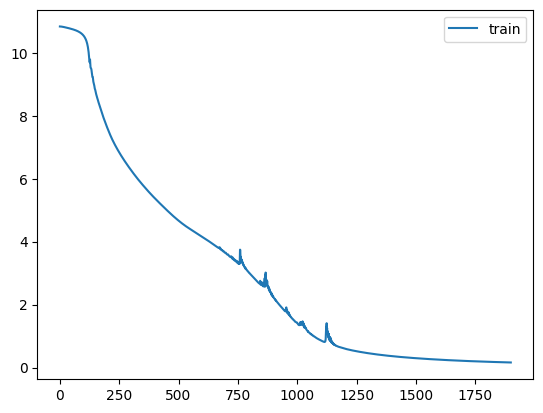

Finished Training
43.73431372642517 seconds
overfit_train_loss=0.14
overfit_train_accuracy=0.97


In [ ]:
# sanity check: overfit on a single batch
model = LMModel5(vocab_size, 64, 2).to(def_device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 3e-3, momentum = 0.9)
_, overfit_train_loss, _, overfit_train_accuracy = train(train_dl, test_dl, model, epochs=2000, one_batch=True)
print(f'{overfit_train_loss=:0.2f}\n{overfit_train_accuracy=:0.2f}')

In [ ]:
# init
model = LMModel5(vocab_size, 64, 2).to(def_device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 3e-5, momentum = 0.9)
model

LMModel5(
  (i_h): Embedding(50257, 64)
  (rnn): RNN(64, 64, num_layers=2, batch_first=True)
  (h_o): Linear(in_features=64, out_features=50257, bias=True)
)

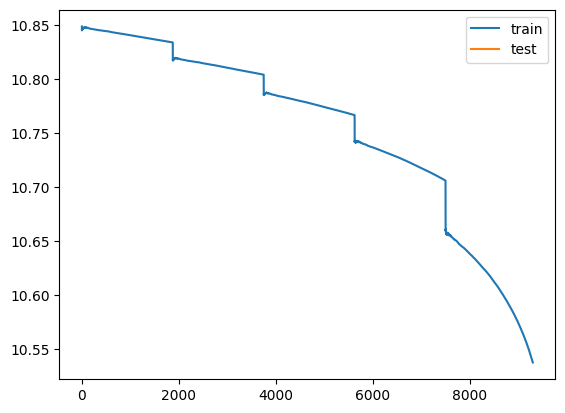

[5,  1875] train loss: 10.525 valid loss: 10.163 valid i: 1874 accuracy: 0.076
Finished Training
270.9875063896179 seconds
CPU times: user 4min 27s, sys: 982 ms, total: 4min 28s
Wall time: 4min 30s


In [ ]:
%%time
# train
epochs = 5
train_time, train_loss, test_loss, accuracy = train(train_dl, test_dl, model, epochs)

In [ ]:
# do some generation
model.reset()
with torch.no_grad():
    prompt = tensor(tds['train'][0]['input_ids'][:seq_len]).view(1, -1)
    prompt_batch = prompt.to(def_device).repeat(bs,1)
    gen_txt = model.generate(prompt_batch, max_new_tokens=20)[0].tolist()
    print(tokenizer.decode(gen_txt))

Once upon a time there was a little boy named Ben. Ben loved to explore diabetic Certain 6 appropriately urinaryonymsinitions Weight Long disappro borrowers Xeon sid sincerity inning NATO BreastIVERiannopoulosrule


In [ ]:
log = load_log(project_dir)

In [ ]:
log = log_run(log, model, device_name, tokenizer, seq_len, bs, epochs, train_dl,
              train_time, train_loss, test_loss, accuracy, gen_txt)

In [ ]:
log

,model,params,device_name,vocab_size,train_tokens,test_tokens,seq_len,batch_size,epochs,train_time,train_loss,test_loss,accuracy,sample
0,LMModel3,6487313,mps,50257,1920000,1920000,3,64,1,284.984944,5.295207,4.621000,0.231564,Once upon a time colorful. They thinks it.\nOn...
1,LMModel3,6487313,Tesla T4,50257,1920000,1920000,3,64,1,53.554449,5.290185,4.608912,0.233263,Once upon a time on the toys in and theyAUD so...
2,LMModel3,6487313,Tesla V100-SXM2-16GB,50257,1920000,1920000,3,64,1,42.597042,5.283650,4.595851,0.232405,Once upon a time tried to worried of. The dog ...
3,LMModel3,6487313,NVIDIA A100-SXM4-40GB,50257,1920000,1920000,3,64,1,33.035805,5.291462,4.612990,0.230420,Once upon a time they in mom needed and Worldw...
4,LMModel4,6487313,mps,50257,1920000,1920000,16,64,1,5874.020087,6.197495,5.400086,0.193369,Once upon a time there was a little boy named ...
5,LMModel4,6487313,Tesla T4,50257,1920000,1920000,16,64,1,74.523791,6.187801,5.388711,0.193032,Once upon a time there was a little boy named ...
6,LMModel4,6487313,Tesla T4,50257,1920000,1920000,16,64,5,376.552830,4.536768,4.486406,0.242363,Once upon a time there was a little boy named ...
7,LMModel5,6499793,Tesla T4,50257,1920000,1920000,16,64,5,278.834241,7.696170,7.607461,0.075804,Once upon a time there was a little boy named ...
8,LMModel5,6499793,Tesla T4,50257,1920000,1920000,16,64,5,270.987506,10.524694,10.163046,0.075741,Once upon a time there was a little boy named ...


In [ ]:
write_log(log, project_dir)

## Notes

As expected, this model is worse. It's deep but without the needed protections around exploding and disappearing gradients. Therefore, we'll move onto LSTM next.

# Training LMModel6 (first LSTM)